In [389]:
%load_ext autoreload
%autoreload 2
from NBT import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [377]:
# Gene SYMBOL 2 ENSG
Symbol2ENSG, Uniprot2ENSG, ENSP2ENSG = LoadIDMapping()

#### SCZ

In [378]:
SCZ_high_conf_gene = pd.read_csv("../dat/network/psychencode/INT-17_SCZ_High_Confidence_Gene_List.csv")
display(SCZ_high_conf_gene.head(2))

,sczgenenames,ensembl_names
0,KMT2E,ENSG00000005483
1,MVP,ENSG00000013364


In [383]:
GeneTest = pd.read_csv("/Users/jiayao/Work/NB_proposal/dat/GWAS/GeneTest/scz.genetest.tsv", delimiter="\t")
GeneTest.head(5)

,GENE,CHR,START,STOP,NSNPS,NPARAM,N,ZSTAT,P
0,SAMD11,1,854993,884961,30,6,150065,1.14730,0.125630
1,NOC2L,1,874583,899679,40,3,150065,1.55460,0.060021
2,KLHL17,1,890967,906099,26,3,150065,1.33840,0.090389
3,PLEKHN1,1,896872,915488,29,7,150065,0.43019,0.333530
4,PERM1,1,905579,922473,40,7,150065,-0.45048,0.673820


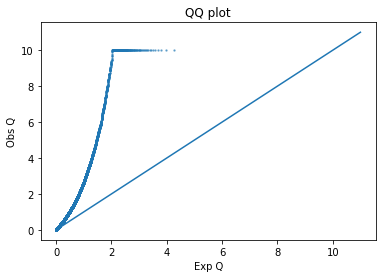

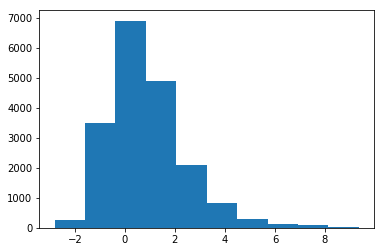

In [418]:
#volcano(GeneTest["P"].values, GeneTest["ZSTAT"])
QQplot(GeneTest["P"].values)
plt.hist(GeneTest["ZSTAT"].values)
plt.show()

In [421]:
Core_Gene = GeneTest[GeneTest["ZSTAT"]>7]["GENE"].values
print(len(Core_Gene))

109


In [142]:
GeneGTF, GeneGTF2 = ReadGeneGTF("../dat/gencode.v19.gene.gtf", withCHR=True)
GeneDict = SNP2Gene(GeneGTF, "../dat/GWAS/PGC/ckqny.scz2snpres.INFO0.9.P0.05.bed.gz",
                   CHROM="hg19chrc", POS="bp", EFFECT="or", SE="se", P="p", )

In [278]:
#RGN = ig.read("../dat/network/saved/psychencode.rgn2.gml")
#RGN = LoadPsychencodeRGN(Symbol2ENSG)

#### PrePPI + SCZ

In [395]:
PrePPI, unmappedUniprot = LoadNetworkPrePPI(Uniprot2ENSG)

/Users/jiayao/anaconda3/lib/python3.7/site-packages/igraph/__init__.py:2280: RuntimeWarning: A non-numeric, non-string, non-boolean edge attribute was ignored at foreign.c:2648
  return writer(f, *args, **kwds)


In [414]:
subPrePPI = PrePPI.subgraph_edges(PrePPI.es.select(weight_ge=1e4))

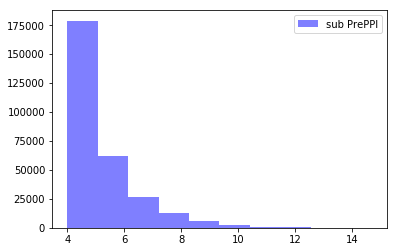

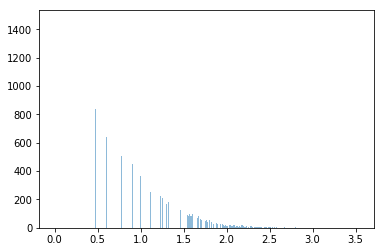

In [417]:
#plt.hist(RGN.degree(), bins=1000, alpha = 0.5, label = "RGN")

plt.hist(np.log10(subPrePPI.es["weight"]), alpha = 0.5, label = "sub PrePPI", color="blue")
#plt.hist(np.log10(PrePPI.es["weight"]), alpha = 0.5, label = "PrePPI", color="red")
plt.legend()
plt.show()
plt.hist(np.log10(subPrePPI.degree()), bins=1000, alpha = 0.5, label = "PrePPI")
plt.show()

In [279]:
print(len(set(Brain_Reg_Net2_csv_trim["Transcription_Factor"].values).union(
    set(Brain_Reg_Net2_csv_trim["Target_Gene"].values))))
print(len(RGN.vs["ENSGID"]))
print(len(GeneDict.keys()))

13464
13329
20345


In [280]:
RGN.es(weight_lt=0.5)

In [281]:
degreesEff = {}
degreesEff[0] = []
degreesNode = {}
degreesNode[0] = []
SCZ_Lost_Genes = []
for i, row in SCZ_high_conf_gene.iterrows():
    ensid = row["ensembl_names"]
    try:
        gene = GeneDict[ensid]
    except KeyError:
        #print (row["sczgenenames"], row["ensembl_names"])
        SCZ_Lost_Genes.append(row["sczgenenames"])
        continue
    if len(gene.SNPs) > 0:
        degreesEff[0].append(gene.max_eff)
        degreesNode[0].append(gene)
        #RGN.vs[.index(ensid)]
print(len(degreesNode[0]))

277


In [299]:
CoreGeneIDs = []
for gene in degreesNode[0]:
    #CoreGeneIDs.gene.GeneID
    if gene.GeneID in ENSID2IDX:
        CoreGeneIDs.append(ENSID2IDX[gene.GeneID])
print(len(CoreGeneIDs))

247


In [375]:
# Filter edges
Cutoff = 0.5
RGN2 = RGN.copy()

for e in RGN.es:
    if e["weight"] < Cutoff:
        RGN2.delete_edges(e.index)

KeyboardInterrupt: 

In [350]:
Nedges = []
for i in range(1000):
    sample = [x.index for x in np.random.choice(RGN.vs, size=247, replace=False)]
    sampleGraph = RGN.subgraph(sample)
    #len(sampleGraph.es)
    Nedges.append(sampleGraph.ecount())

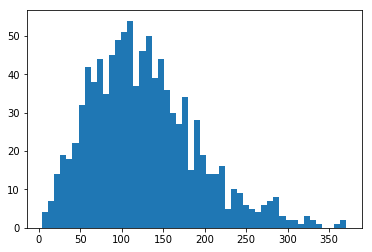

In [351]:
plt.hist(Nedges, bins=50)
plt.show()

In [303]:
CoreGeneNet = RGN.subgraph(CoreGeneIDs)

In [349]:
CoreGeneNet.ecount()

56

In [358]:
CoreGeneIDs[:2]

[8005, 12575]

In [359]:
RGN.get_shortest_paths(8005, 12575)

[[8005, 7, 12575]]

In [370]:
pathDist = []
for v1, v2 in itertools.combinations(CoreGeneIDs, r=2):
    #print(v1, v2)
    path = len(RGN.get_shortest_paths(v1, v2)[0])-1
    pathDist.append(path)

In [372]:
pathDist2 = []
sample = [x.index for x in np.random.choice(RGN.vs, size=247, replace=False)]
for v1, v2 in itertools.combinations(sample, r=2):
    #print(v1, v2)
    path = len(RGN.get_shortest_paths(v1, v2)[0])-1
    pathDist2.append(path)

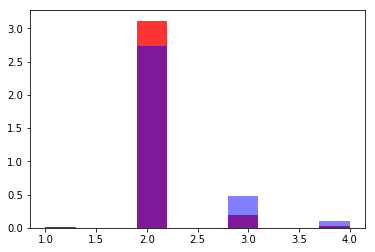

2.067904282281689 2.201474605839176


MannwhitneyuResult(statistic=410390403.5, pvalue=0.0)

In [373]:
plt.hist(pathDist, color="red", alpha=0.8, density=1)
plt.hist(pathDist2, color = 'blue', alpha=.5, density=1)
plt.show()
print(np.mean(pathDist), np.mean(pathDist2))
mannwhitneyu(pathDist, pathDist2)

In [352]:
CoreGeneeCcentricity = RGN.eccentricity(CoreGeneIDs)
AllGeneeCcentricity = RGN.eccentricity()

In [355]:
CoreGeneeCcentricity[:10]

[4.0, 4.0, 4.0, 4.0, 4.0, 3.0, 4.0, 4.0, 4.0, 3.0]

In [356]:
AllGeneeCcentricity[:10]

[3.0, 4.0, 4.0, 3.0, 4.0, 3.0, 4.0, 3.0, 3.0, 3.0]

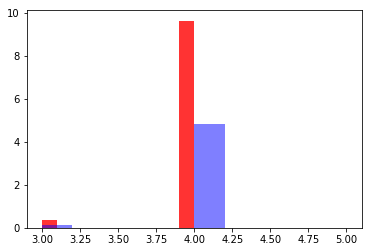

3.9635627530364372 3.9717158076374823


MannwhitneyuResult(statistic=1632850.0, pvalue=0.2409400693121318)

In [354]:
plt.hist(CoreGeneeCcentricity, color="red", alpha=0.8, density=1)
plt.hist(AllGeneeCcentricity, color = 'blue', alpha=.5, density=1)
plt.show()
print(np.mean(CoreGeneeCcentricity), np.mean(AllGeneeCcentricity))
mannwhitneyu(CoreGeneeCcentricity, AllGeneeCcentricity)

In [336]:
CoreGeneCloseness = RGN.closeness(CoreGeneIDs)
AllGeneCloseness = RGN.closeness()

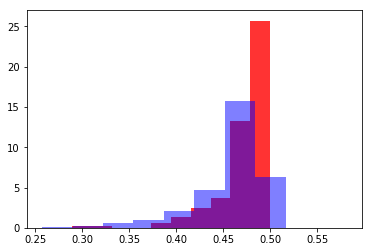

0.47115834567716425 0.45774358496013257


MannwhitneyuResult(statistic=1209420.0, pvalue=4.1706111331002457e-13)

In [345]:
plt.hist(CoreGeneCloseness, color="red", alpha=0.8, density=1)
plt.hist(AllGeneCloseness, color = 'blue', alpha=.5, density=1)
plt.show()
print(np.mean(CoreGeneCloseness), np.mean(AllGeneCloseness))
mannwhitneyu(CoreGeneCloseness, AllGeneCloseness)

In [282]:
#GetIndexOfAllNodes
ENSID2IDX = {}
for idx, v in enumerate(RGN.vs):
    ENSID2IDX[v["ENSGID"]] = idx

In [295]:
PreNodes = set(degreesNode[0])
Not_In_Network = []
for i in range(1,11,1):
    degreesEff[i] = []
    degreesNode[i] = []
    for gene in degreesNode[i-1]:
        ENSGID = gene.GeneID
        try:
            NodeID = ENSID2IDX[ENSGID]
        except:
            Not_In_Network.append(ENSGID)
            continue
        if ENSGID in ENSID2IDX:
            for edge in RGN.es.select(_source = NodeID):
                #print(NodeID, edge.tuple)
                target = edge.tuple[1]
                if target not in PreNodes:
                    degreesNode[i].append(RGN.vs[target]["ENSGID"])
            for edge in RGN.es.select(_target = NodeID):
                #print(NodeID, edge.tuple)
                source = edge.tuple[0]
                if source not in PreNodes:
                    degreesNode[i].append(RGN.vs[source]["ENSGID"])
    degreesNode[i] = list(set(degreesNode[i]))
    for ensgid in degreesNode[i]:
        degreesEff[i].append(GeneDict[ensgid].max_eff)
    print(len(degreesNode[i]))
    PreNodes = PreNodes.union(set(degreesNode[i]))

KeyError: 'ENSG00000230124'

In [290]:
print(RGN.vs[273], RGN.vs[273].index, RGN.es[1142], RGN.es[1142].tuple)

igraph.Vertex(<igraph.Graph object at 0x1a7cf3ce58>, 273, {'ENSGID': 'ENSG00000025434'}) 273 igraph.Edge(<igraph.Graph object at 0x1a7cf3ce58>, 1142, {'weight': 0.11449726357037401, 'region': 'chr19:45414026-45415025', 'TF': 'NR1H3', 'Taget': 'APOE'}) (273, 390)


1.09101 1.062365 1.06332
1.0945847653429601 1.0697580970504281 1.0694282787526546


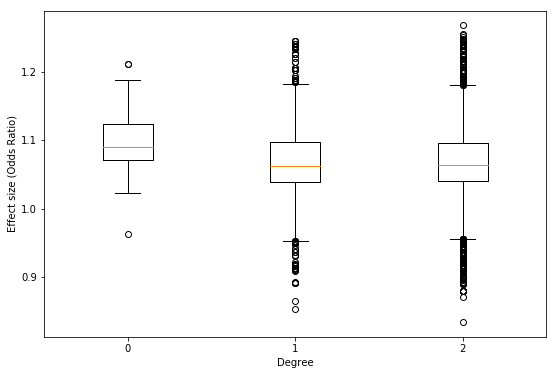

In [240]:
data_to_plot = [degreesEff[0], degreesEff[1], degreesEff[2]]
print(np.median(degreesEff[0]),np.median(degreesEff[1]),np.median(degreesEff[2]))
print(np.mean(degreesEff[0]),np.mean(degreesEff[1]),np.mean(degreesEff[2]))
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['0', '1', '2'])
ax.set_xlabel("Degree")
ax.set_ylabel("Effect size (Odds Ratio)")
plt.show()

277


In [103]:
edges = pd.read_csv("/Users/jiayao/Work/NB_proposal/dat/network/9606.protein.links.v11.0.txt", delimiter=" ")

In [105]:
Brain_Reg_Net2_csv_trim.head()

,Transcription_Factor,Target_Gene,Enhancer_Region,Edge_Weight
0,BARHL2,SHC1,chr1:154869072-154870071,0.284806
2,MNT,SHC1,chr1:154716711-154717710,0.312268
6,NR2F2,SHC1,chr1:154722868-154723867,0.122871
68,PLAGL1,SHC1,chr1:154548318-154549317,0.114818
194,HMX3,CDCA2,chr8:25045544-25046543,0.289291


In [106]:
#edges1 = edges[edges["combined_score"]>900]
#edges1 = edges1[(edges1["protein1"].isin(set(GeneDict.keys())))&(edges["protein2"].isin(set(GeneDict.keys())))]

In [107]:
print(edges.shape, edges1.shape)

NameError: name 'edges1' is not defined

In [ ]:
plt.hist(Brain_Reg_Net2_csv["Edge_Weight"].values, bins=500)
plt.xlim((0,2))
plt.show()

In [108]:
for K in list(GeneDict.keys()):
    if len(GeneDict[K].SNPs) == 0:
        GeneDict.pop(K)
len(GeneDict)

16437

In [109]:
SymbolGeneDict = {}
for k,v in GeneDict.items():
    SymbolGeneDict[v.GeneName] = v

In [174]:
graph = {}
count = 0
for i, row in Brain_Reg_Net2_csv_trim.iterrows():
    g1, g2 = row["Transcription_Factor"], row["Target_Gene"]
    #print(g1, g2)
    if g1 not in SymbolGeneDict or g2 not in SymbolGeneDict:
        continue
    if g1 not in graph:
        graph[g1] = []
    if g2 not in graph:
        graph[g2] = []
    graph[g1].append(g2)
    graph[g2].append(g1)
    if count % 1000 == 0:
        sys.stdout.write("\r%d"%count)
    count += 1

278000

In [172]:
Brain_Reg_Net2_csv_trim.shape

(372661, 4)

In [111]:
print(len(graph.keys()))

11297


In [112]:
degreesNode[0] = [gene.GeneName for gene in degreesNode[0]]
PreNodes = set(degreesNode[0])
print(len(PreNodes))
for i in range(1,11,1):
    degreesEff[i] = []
    degreesNode[i] = []
    for gene in degreesNode[i-1]:
        symbol = gene
        if symbol in graph:
            for node in graph[symbol]:
                if node not in PreNodes:
                    degreesNode[i].append(node)
    degreesNode[i] = list(set(degreesNode[i]))
    for symbol in degreesNode[i]:
        degreesEff[i].append(SymbolGeneDict[symbol].max_eff)
    print(len(degreesNode[i]))
    PreNodes = PreNodes.union(set(degreesNode[i]))

277
2102
8947
0
0
0
0
0
0
0
0


In [113]:
2878 + 538 + 227 + 1

3644

1.085345 1.062365 1.06332
1.0926595222929938 1.0697580970504281 1.0694282787526546


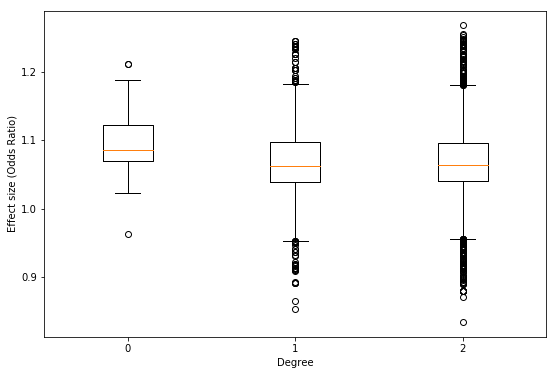

In [114]:
data_to_plot = [degreesEff[0], degreesEff[1], degreesEff[2]]
print(np.median(degreesEff[0]),np.median(degreesEff[1]),np.median(degreesEff[2]))
print(np.mean(degreesEff[0]),np.mean(degreesEff[1]),np.mean(degreesEff[2]))
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['0', '1', '2'])
ax.set_xlabel("Degree")
ax.set_ylabel("Effect size (Odds Ratio)")
plt.show()

In [115]:
t1, p1 = stats.ttest_ind(degreesEff[0],degreesEff[1])
print(t1, p1)
t2, p2 = stats.ttest_ind(degreesEff[1],degreesEff[2])
print(t2, p2)

8.212674941550832 3.4826177291998446e-16
0.2986077445284085 0.7652449721087354


##### SCZ PrePPI

In [116]:
PrePPI = pd.read_csv("../dat/network/preppi_final600.txt", delimiter="\t")

In [117]:
PrePPI.head()

,prot1,prot2,str_score,protpep_score,str_max_score,red_score,ort_score,phy_score,coexp_score,go_score,total_score,dbs,pubs,exp_score,final_score
0,Q13131,P14625,18.5900,6.44772,18.5900,4.2492,0.6153,2.4160,9.4687,10.80,12008.400,NaN,NaN,NaN,12008.400
1,P06400,Q96N96,1.8315,14.32220,14.3222,4.2492,0.0000,2.4160,2.1077,10.80,3346.930,NaN,NaN,NaN,3346.930
2,Q7Z6V5,Q8NCE0,4.5712,0.00000,4.5712,0.0000,0.0000,1.5978,9.4687,24.11,1667.400,NaN,NaN,NaN,1667.400
3,P37058,P15428,484.5640,0.00000,484.5640,1.7740,0.6153,2.4160,1.1757,2.07,3109.970,NaN,NaN,NaN,3109.970
4,O00468,Q9NR23,34.0309,0.00000,34.0309,0.5125,0.0000,2.4160,2.7714,5.86,684.323,NaN,NaN,NaN,684.323


In [129]:
degreesEff = {}
degreesEff[0] = []
degreesNode = {}
degreesNode[0] = []
for i, row in SCZ_high_conf_gene.iterrows():
    ensid = row["ensembl_names"]
    try:
        gene = GeneDict[ensid]
    except KeyError:
        #print (row["sczgenenames"], row["ensembl_names"])
        pass
    if len(gene.SNPs) > 0:
        degreesEff[0].append(gene.max_eff)
        degreesNode[0].append(gene)

In [121]:
IDGeneDict = {}
for k,v in GeneDict.items():
    IDGeneDict[v.GeneID] = v

graph2 = {}
count = 0
for i, row in PrePPI.iterrows():
    prot1, prot2 = row["prot1"], row["prot2"]
    try:
        g1, g2 = Uniprot2ENSG[prot1], Uniprot2ENSG[prot2]
    except KeyError:
        continue
    #print(g1, g2)
    if g1 not in IDGeneDict or g2 not in IDGeneDict:
        continue
    if g1 not in graph2:
        graph2[g1] = []
    if g2 not in graph2:
        graph2[g2] = []
    graph2[g1].append(g2)
    graph2[g2].append(g1)
    if count % 1000 == 0:
        sys.stdout.write("\r%d"%i)
    count += 1

1544550

In [131]:
degreesNode[0] = [gene.GeneName for gene in degreesNode[0]]
degreesNode[0]

['KMT2E',
 'MVP',
 'MTMR11',
 'PLEKHO1',
 'HSD17B6',
 'NR1H3',
 'SPA17',
 'KDM4A',
 'NGEF',
 'SREBF1',
 'NT5C2',
 'KIF22',
 'DDHD2',
 'TMED2',
 'SF3B2',
 'PITPNM2',
 'PUS7',
 'CACNA1I',
 'GRAP2',
 'RANGAP1',
 'PPP1R16B',
 'NDFIP2',
 'MAZ',
 'CDIPT',
 'TRIM35',
 'RAI1',
 'SIAE',
 'MDK',
 'AMBRA1',
 'MADD',
 'OGFOD2',
 'GTF2H3',
 'DDX55',
 'EFHD1',
 'NEU2',
 'PRPF3',
 'PTK2B',
 'CHRNA2',
 'EPHX2',
 'CRY2',
 'ARHGAP9',
 'LRP1',
 'KLC1',
 'ZSWIM6',
 'ARHGEF16',
 'HIP1R',
 'FAM83F',
 'DDB2',
 'ACP2',
 'SRPK2',
 'PHF21A',
 'OS9',
 'VPS45',
 'SBNO1',
 'VPS37B',
 'RBM26',
 'GID4',
 'RERE',
 'PRDM16',
 'PTPRF',
 'SF3B4',
 'ECM1',
 'TARS2',
 'ANP32E',
 'STAR',
 'CNNM2',
 'DGKZ',
 'CELF1',
 'DOC2A',
 'HIRIP3',
 'TAOK2',
 'ABCB9',
 'CACNA1C',
 'RABGAP1L',
 'PCGF6',
 'TDRD9',
 'BAG4',
 'CACNA1D',
 'PEX10',
 'SV2A',
 'CTSS',
 'ASB5',
 'LETM2',
 'BAG5',
 'STAT6',
 'MARS',
 'C16orf92',
 'PRRT2',
 'ZEB2',
 'INO80E',
 'ESCO2',
 'ATPAF2',
 'EFEMP2',
 'MUS81',
 'CFL1',
 'SNX32',
 'OVOL1',
 'RNASEH2C',
 'K

In [135]:
#degreesNode[0] = [gene.GeneName for gene in degreesNode[0]]
PreNodes = set(degreesNode[0])
print(len(PreNodes))
for i in range(1,11,1):
    degreesEff[i] = []
    degreesNode[i] = []
    for gene in degreesNode[i-1]:
        try:
            symbol = Symbol2ENSG[gene]
        except:
            continue
        if symbol in graph2:
            for node in graph2[symbol]:
                if node not in PreNodes:
                    degreesNode[i].append(node)
    degreesNode[i] = list(set(degreesNode[i]))
    for symbol in degreesNode[i]:
        try:
            degreesEff[i].append(SymbolGeneDict[symbol].max_eff)
        except:
            continue
    print(len(degreesNode[i]))
    PreNodes = PreNodes.union(set(degreesNode[i]))

277
9061
0
0
0
0
0
0
0
0
0


1.08513 nan nan
1.0926142679127726 nan nan


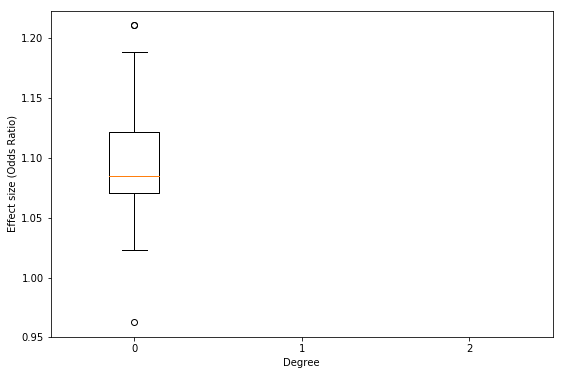

In [137]:
data_to_plot = [degreesEff[0], degreesEff[1], degreesEff[2]]
print(np.median(degreesEff[0]),np.median(degreesEff[1]),np.median(degreesEff[2]))
print(np.mean(degreesEff[0]),np.mean(degreesEff[1]),np.mean(degreesEff[2]))
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['0', '1', '2'])
ax.set_xlabel("Degree")
ax.set_ylabel("Effect size (Odds Ratio)")
plt.show()

#### ASD

In [31]:
df = pd.read_csv("/Users/jiayao/Work/spark/dat/SFARI-Gene_genes_05-06-2019release_05-22-2019export.csv")
ASD_Core = df[df["gene-score"].isin([1.0, 2.0])]["gene-symbol"].values

In [47]:
GeneGTF = ReadGeneGTF("../dat/gencode.v19.gene.gtf")
GeneDict = SNP2Gene(GeneGTF, "../dat/GWAS/PGC/iPSYCH-PGC_ASD_Nov2017.INFO0.9.P0.05.sort.bed.gz",
                   CHROM="CHR", POS="BP", EFFECT="OR", SE="SE", P="P")

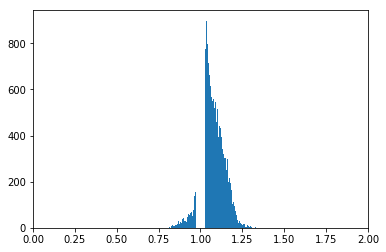

In [48]:
Effects = []
for k, v in GeneDict.items():
    if len(v.SNPs) == 0:
        continue
    Effects.append(v.max_eff)
plt.hist(Effects, bins=100)
plt.xlim([0,2])
plt.show()

In [80]:
degreesEff = {}
degreesEff[0] = []
degreesNode = {}
degreesNode[0] = []
for gene_symbol in ASD_Core:
    try:
        ensg = symbol2ensg[gene_symbol]
        gene = GeneDict[ensid]
    except KeyError:
        print (gene_symbol)
        continue
    if len(gene.SNPs) > 0:
        degreesEff[0].append(gene.max_eff)
        degreesNode[0].append(gene)

MSNP1AS


In [75]:
Brain_Reg_Net2_csv_trim = Brain_Reg_Net2_csv.drop_duplicates(
    subset=["Transcription_Factor", "Target_Gene"], keep="first")

In [76]:
SymbolGeneDict = {}
for k,v in GeneDict.items():
    SymbolGeneDict[v.GeneName] = v

In [77]:
graph = {}
count = 0
for i, row in Brain_Reg_Net2_csv_trim.iterrows():
    g1, g2 = row["Transcription_Factor"], row["Target_Gene"]
    #print(g1, g2)
    if g1 not in SymbolGeneDict or g2 not in SymbolGeneDict:
        continue
    if g1 not in graph:
        graph[g1] = []
    if g2 not in graph:
        graph[g2] = []
    graph[g1].append(g2)
    graph[g2].append(g1)
    if count % 1000 == 0:
        sys.stdout.write("\r%d"%i)
    count += 1

4148287

In [78]:
degreesNode[0] = [gene.GeneName for gene in degreesNode[0]]

In [79]:
PreNodes = set(degreesNode[0])
print(len(PreNodes))
for i in range(1,11,1):
    degreesEff[i] = []
    degreesNode[i] = []
    for gene in degreesNode[i-1]:
        symbol = gene
        if symbol in graph:
            for node in graph[symbol]:
                if node not in PreNodes:
                    degreesNode[i].append(node)
    degreesNode[i] = list(set(degreesNode[i]))
    for symbol in degreesNode[i]:
        degreesEff[i].append(SymbolGeneDict[symbol].max_eff)
    print(len(degreesNode[i]))
    PreNodes = PreNodes.union(set(degreesNode[i]))

1
0
0
0
0
0
0
0
0
0
0


1.14214 nan nan
1.1421399999999995 nan nan


/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jiayao/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


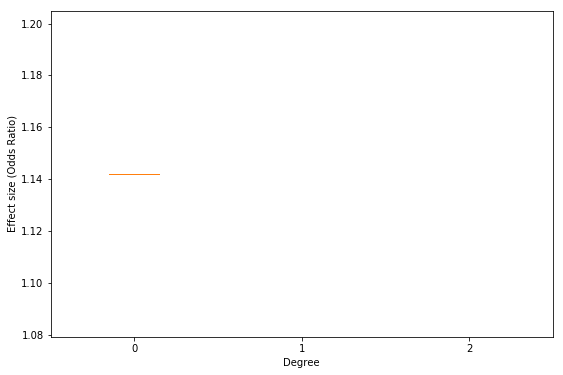

In [67]:
data_to_plot = [degreesEff[0], degreesEff[1], degreesEff[2]]
print(np.median(degreesEff[0]),np.median(degreesEff[1]),np.median(degreesEff[2]))
print(np.mean(degreesEff[0]),np.mean(degreesEff[1]),np.mean(degreesEff[2]))
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot)
ax.set_xticklabels(['0', '1', '2'])
ax.set_xlabel("Degree")
ax.set_ylabel("Effect size (Odds Ratio)")
plt.show()

In [34]:
from biomart import BiomartServer
server = BiomartServer( "http://www.ensembl.org/biomart/martservice" )
# set verbose to True to get some messages
server.verbose = True

In [35]:
server.show_databases()

[BiomartServer:'http://www.ensembl.org/biomart/martservice'] Fetching databases
{'ENSEMBL_MART_ENSEMBL': Ensembl Genes 98,
 'ENSEMBL_MART_FUNCGEN': Ensembl Regulation 98,
 'ENSEMBL_MART_GENOMIC': Genomic features 98,
 'ENSEMBL_MART_MOUSE': Mouse strains 98,
 'ENSEMBL_MART_ONTOLOGY': Ontology,
 'ENSEMBL_MART_SEQUENCE': Sequence,
 'ENSEMBL_MART_SNP': Ensembl Variation 98}


In [42]:
ENSEMBL = server.datasets['hsapiens_gene_ensembl']
ENSEMBL.show_attributes()

[BiomartDataset:'hsapiens_gene_ensembl'] Fetching attributes
{'3_utr_end': '3' UTR end' (default: False),
 '3_utr_start': '3' UTR start' (default: False),
 '3utr': '3' UTR' (default: False),
 '5_utr_end': '5' UTR end' (default: False),
 '5_utr_start': '5' UTR start' (default: False),
 '5utr': '5' UTR' (default: False),
 'abrachyrhynchus_homolog_associated_gene_name': 'Pink-footed goose gene name' (default: False),
 'abrachyrhynchus_homolog_canonical_transcript_protein': 'Query protein or transcript ID' (default: False),
 'abrachyrhynchus_homolog_chrom_end': 'Pink-footed goose chromosome/scaffold end (bp)' (default: False),
 'abrachyrhynchus_homolog_chrom_start': 'Pink-footed goose chromosome/scaffold start (bp)' (default: False),
 'abrachyrhynchus_homolog_chromosome': 'Pink-footed goose chromosome/scaffold name' (default: False),
 'abrachyrhynchus_homolog_dn': 'dN with Pink-footed goose' (default: False),
 'abrachyrhynchus_homolog_ds': 'dS with Pink-footed goose' (default: False),
 'ab

 'gmorhua_homolog_ds': 'dS with Cod' (default: False),
 'gmorhua_homolog_ensembl_gene': 'Cod gene stable ID' (default: False),
 'gmorhua_homolog_ensembl_peptide': 'Cod protein or transcript stable ID' (default: False),
 'gmorhua_homolog_goc_score': 'Cod Gene-order conservation score' (default: False),
 'gmorhua_homolog_orthology_confidence': 'Cod orthology confidence [0 low, 1 high]' (default: False),
 'gmorhua_homolog_orthology_type': 'Cod homology type' (default: False),
 'gmorhua_homolog_perc_id': '%id. target Cod gene identical to query gene' (default: False),
 'gmorhua_homolog_perc_id_r1': '%id. query gene identical to target Cod gene' (default: False),
 'gmorhua_homolog_subtype': 'Last common ancestor with Cod' (default: False),
 'gmorhua_homolog_wga_coverage': 'Cod Whole-genome alignment coverage' (default: False),
 'go_id': 'GO term accession' (default: False),
 'go_linkage_type': 'GO term evidence code' (default: False),
 'goslim_goa_accession': 'GOSlim GOA Accession(s)' (defa

 'nbrichardi_homolog_goc_score': 'Lyretail cichlid Gene-order conservation score' (default: False),
 'nbrichardi_homolog_orthology_confidence': 'Lyretail cichlid orthology confidence [0 low, 1 high]' (default: False),
 'nbrichardi_homolog_orthology_type': 'Lyretail cichlid homology type' (default: False),
 'nbrichardi_homolog_perc_id': '%id. target Lyretail cichlid gene identical to query gene' (default: False),
 'nbrichardi_homolog_perc_id_r1': '%id. query gene identical to target Lyretail cichlid gene' (default: False),
 'nbrichardi_homolog_subtype': 'Last common ancestor with Lyretail cichlid' (default: False),
 'nbrichardi_homolog_wga_coverage': 'Lyretail cichlid Whole-genome alignment coverage' (default: False),
 'ncoils': 'Coiled-coils (Ncoils)' (default: False),
 'ncoils_end': 'Coiled-coils (Ncoils) end' (default: False),
 'ncoils_start': 'Coiled-coils (Ncoils) start' (default: False),
 'neugenii_homolog_associated_gene_name': 'Wallaby gene name' (default: False),
 'neugenii_hom

 'version': 'Version (gene)' (default: False),
 'vpacos_homolog_associated_gene_name': 'Alpaca gene name' (default: False),
 'vpacos_homolog_canonical_transcript_protein': 'Query protein or transcript ID' (default: False),
 'vpacos_homolog_chrom_end': 'Alpaca chromosome/scaffold end (bp)' (default: False),
 'vpacos_homolog_chrom_start': 'Alpaca chromosome/scaffold start (bp)' (default: False),
 'vpacos_homolog_chromosome': 'Alpaca chromosome/scaffold name' (default: False),
 'vpacos_homolog_dn': 'dN with Alpaca' (default: False),
 'vpacos_homolog_ds': 'dS with Alpaca' (default: False),
 'vpacos_homolog_ensembl_gene': 'Alpaca gene stable ID' (default: False),
 'vpacos_homolog_ensembl_peptide': 'Alpaca protein or transcript stable ID' (default: False),
 'vpacos_homolog_goc_score': 'Alpaca Gene-order conservation score' (default: False),
 'vpacos_homolog_orthology_confidence': 'Alpaca orthology confidence [0 low, 1 high]' (default: False),
 'vpacos_homolog_orthology_type': 'Alpaca homolog

In [1]:
#asd
18381 + 27969

46350

In [2]:
#scz
36989 + 113075

150064

In [162]:
edges.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000272298,490
1,9606.ENSP00000000233,9606.ENSP00000253401,198
2,9606.ENSP00000000233,9606.ENSP00000401445,159
3,9606.ENSP00000000233,9606.ENSP00000418915,606
4,9606.ENSP00000000233,9606.ENSP00000327801,167


In [166]:
graph = {}
count = 0
for i, row in edges1.iterrows():
    g1, g2 = row["protein1"].split(".")[1], row["protein2"].split(".")[1]
    #print(g1, g2)
    if g1 not in GeneDict or g2 not in GeneDict:
        continue
    if g1 not in graph:
        graph[g1] = []
    if g2 not in graph:
        graph[g2] = []
    graph[g1].append(g2)
    graph[g2].append(g1)
    if count % 1000 == 0:
        sys.stdout.write("\r%d"%i)
        count += 1

In [167]:
print(len(graph.keys()))

0
